# Try to write tzar-function for basin coordinates transfer to modeling-ready dataframe

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# source: my code from sandbox/WFDEI_to_dataframe.ipynb

# convert our basin scheme to simple lists 
def schema_to_lists(path):
    schema = pd.read_csv(path, usecols=[0, 1])
    lat = schema.Y.values
    lon = schema.X.values
    return lat, lon

# read our WFDEI dataset and cutting it through our scheme coordinates
# xarray dataframe as output
def data_reading_cutting(path, lat, lon):
    data = xr.open_dataset(path, decode_times=False)
    data['time'] = pd.date_range('1979-01-01', '2014-12-31', name='time')
    return data.sel_points(lat = lat, lon = lon)

# convert our xarray dataframe to simple pandas dataframe
def xdata_to_pdata(xdata, var_name):
    pdata = pd.DataFrame(index=pd.date_range('1979-01-01', '2014-12-31', name='Date'))
    for i in range(xdata.dims['points']):
        pdata[var_name+'_'+str(i)] = xdata[var_name][i].data
    return pdata

In [4]:
# source: my code from sandbox/WFDEI_to_dataframe.ipynb

# define files and variables been used

wfdei_files = ['../data/Tair_daily_WFDEI_197901_201412_NPT.nc',
               '../data/Rainf_CRU_daily_WFDEI_197901_201412_NPT.nc',
               '../data/Snowf_CRU_daily_WFDEI_197901_201412_NPT.nc'
              ]

wfdei_vars = ['Tair', 
              'Rainf', 
              'Snowf'
             ]

In [5]:
def dataframe_construction(path_to_scheme):
    # Part 1 - wrap all data from .nc files
    # to one pandas dataframe constructing
    # in spatially-distributed way:
    # we have (variables)*(grid cells in scheme)
    # columns in our dataframe
    
    # initialize intermediate results 
    # holding list
    stack = []
    
    # run the cycle through our .nc data
    for wfdei_file, wfdei_var in zip(wfdei_files, wfdei_vars):
        
        # 1. retrieve our scheme coordinates
        lat, lon = schema_to_lists(path_to_scheme)

        # 2. cut or data along the scheme coordinates provided
        chunk = data_reading_cutting(wfdei_file, lat, lon)

        # 3. retrive pandas dataframe of needed variable
        #    each column - array of variable in one wfdei cell grid
        pdata = xdata_to_pdata(chunk, wfdei_var)

        # 4. append pdata of each var to _stack_ for further concatenation
        stack.append(pdata)

    # 5. concatenate parts of our data in _stack_ with one pandas dataframe
    result = pd.concat(stack, axis=1)
    
    # Part 2 - convert derived in part 1 pandas dataframe
    # to spatially(weighted)-averaged lumped pandas dataframe
    # ready-made for using with conceptual models
    
    # 1. read in basin shematization file
    coord = pd.read_csv(path_to_scheme, usecols=[0, 1])
    # 2. rename columns
    coord.columns = ['lon','lat']
    # 3. calculate weights of each cell for further weighted averaging
    coord['weights'] = (np.cos((coord['lat'] + 0.25)*np.pi/180) + np.cos((coord['lat'] - 0.25)*np.pi/180))
    coord['weights'] = coord['weights']/np.sum(coord['weights'])
    # 4. cut necessary variables (Rainf, Snowf, Tair)
    rain = result[['Rainf_'+str(point) for point in coord.index]]
    snow = result[['Snowf_'+str(point) for point in coord.index]]
    temp = result[['Tair_'+str(point) for point in coord.index]]
    # 5. convertion stage
    # 5.1. convert precipitation (average rate mm/sec for 24 hours) to (sum of mm for whole day) 
    # just multiply all values by 60sec*60min*24h
    rain = rain*(60*60*24)
    snow = snow*(60*60*24)
    #convert temperature from Kelvins to Celsius
    temp = temp-273.15
    #summarize rain and snow to one precipitation parameter
    prec = rain.add(snow.values)
    # 6. final stage
    # 6.1 weighted averaging (sum of weight_i*value_i)
    prec_avrg = prec.mul(coord['weights'].values, axis=1).sum(axis=1)
    temp_avrg = temp.mul(coord['weights'].values, axis=1).sum(axis=1)
    # 6.2 wrap-up all in one ready-made pandas dataframe
    lumped_data = pd.DataFrame({'Temp': temp_avrg, 'Prec': prec_avrg}, index=temp_avrg.index)
    
    # Part 3
    # calculate daily evaporation from long-term monthly values for this domain
    evap_monthly = np.loadtxt('../data/Evap_monthly_constants.txt')
    lumped_data['Evap'] = lumped_data.index.map(lambda x: evap_monthly[x.month-1])
    
    return lumped_data

In [7]:
pur = dataframe_construction('../data/pur_scheme.csv')

In [8]:
pur_previous = pd.read_csv('../../../Hydro/Pur_Taz_Nadym/s-HBV/data/pur_avrg.csv', index_col=0, parse_dates=True)

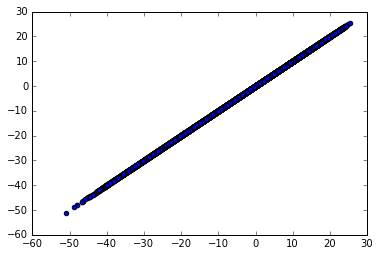

In [9]:
plt.scatter(pur.Temp, pur_previous.Temp)

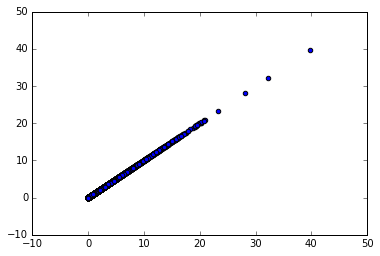

In [10]:
plt.scatter(pur.Prec, pur_previous.Prec)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../tools/')
import wfdei_to_lumped_dataframe

In [2]:
pur = wfdei_to_lumped_dataframe.dataframe_construction('../data/pur_scheme.csv')
pur_previous = pd.read_csv('../../../Hydro/Pur_Taz_Nadym/s-HBV/data/pur_avrg.csv', index_col=0, parse_dates=True)

In [6]:
print('My domain constants :', [0.6,1.9,2.4,1.8,1.4,1.3,1.0,0.8,0.6,0.4,0.2,0.3])
print('Averaged from daily :', np.array([pur.ix[pur.index.month == x, 'Evap'].mean() for x in range(1, 13)]))

My domain constants : [0.6, 1.9, 2.4, 1.8, 1.4, 1.3, 1.0, 0.8, 0.6, 0.4, 0.2, 0.3]
Averaged from daily : [ 0.6  1.9  2.4  1.8  1.4  1.3  1.   0.8  0.6  0.4  0.2  0.3]
